In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

from theano import tensor as tt
from scipy import stats
import theano

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 14 - Multinomial processing trees

## 14.1 Multinomial processing model of pair-clustering
Multinomial processing trees (MPTs: Batchelder & Riefer, 1980, 1986; Chechile, 1973; Chechile & Meyer, 1976) provide one approach to modeling the finding that semantically related items are often recalled consecutively. An MPT model assumes that observed behavior arises from a sequence of cognitive events, able to be represented by a rooted tree architecture

$$ c,r,u \sim \text{Beta}(1,1)  $$
$$ \theta_{1} = cr $$
$$ \theta_{2} = (1\,-\,c)u^2 $$
$$ \theta_{3} = 2u\,(1\,-\,c)\,(1\,-\,u) $$
$$ \theta_{4} = c\,(1\,-\,r)\,+\,(1\,-\,c)\,(1\,-\,u)^2 $$
$$ \mathbf k \sim \text{Multinomial}(\mathbf \theta,n)$$

In [2]:
indiv_trial = []
Nt = 3
kall = np.array([[45, 24, 97, 254],
                 [106, 41, 107, 166],
                 [243, 64, 65, 48]])

kshared = theano.shared(kall[0, :])
with pm.Model() as model1:
    c = pm.Beta('c', alpha=1, beta=1)
    r = pm.Beta('r', alpha=1, beta=1)
    u = pm.Beta('u', alpha=1, beta=1)

    t1 = c * r
    t2 = (1 - c) * (u**2)
    t3 = 2 * u * (1 - c) * (1 - u)
    t4 = c * (1 - r) + (1 - c) * (1 - u)**2

    kobs = pm.Multinomial("kobs",
                          p=[t1, t2, t3, t4], n=kshared.sum(), observed=kshared)

with model1:
    indiv_trial.append(pm.sample(1000, tune=1000))

kshared.set_value(kall[1, :])
with model1:
    indiv_trial.append(pm.sample(1000, tune=1000))

kshared.set_value(kall[2, :])
with model1:
    indiv_trial.append(pm.sample(1000, tune=1000))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [u_logodds__, r_logodds__, c_logodds__]
100%|██████████| 2000/2000 [00:04<00:00, 400.96it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [u_logodds__, r_logodds__, c_logodds__]
100%|██████████| 2000/2000 [00:03<00:00, 515.12it/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS us

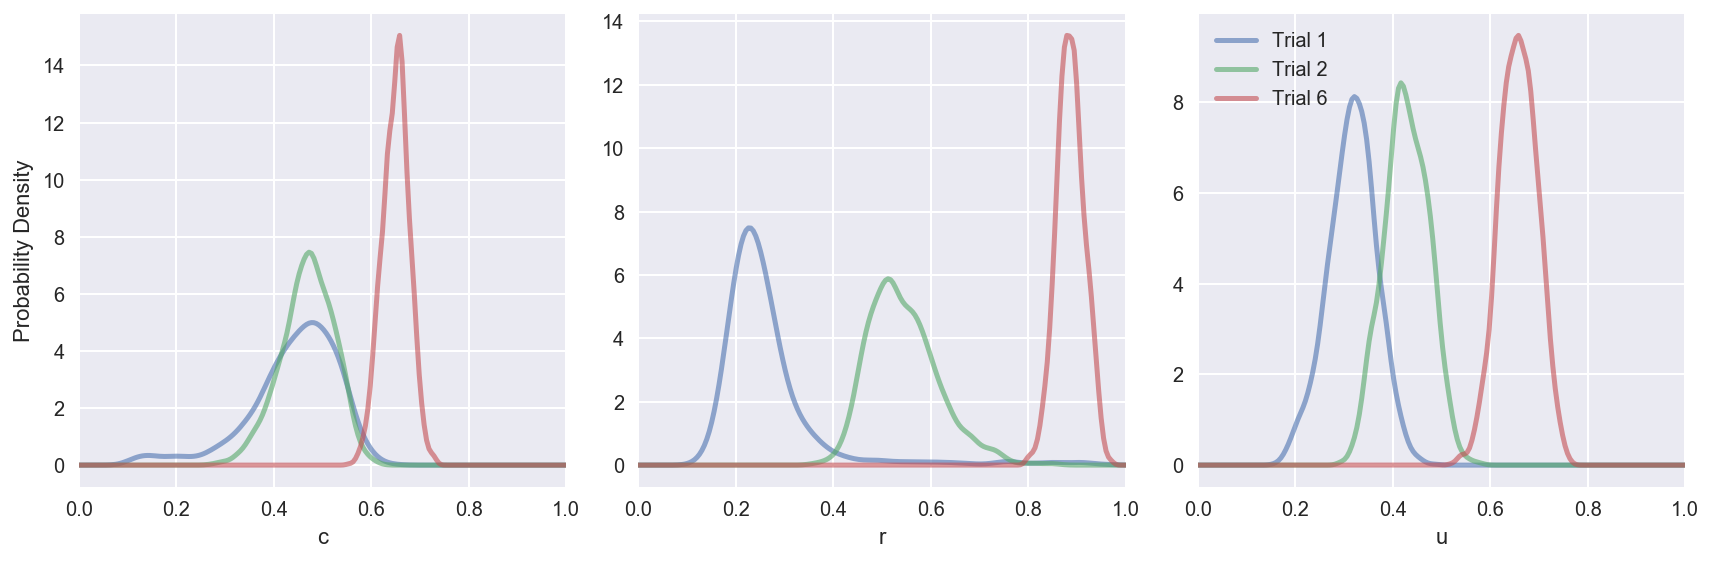

In [3]:
from scipy.stats.kde import gaussian_kde

_, axes = plt.subplots(1, 3, figsize=(12, 4))

x1 = np.linspace(0, 1, 200)
plotparm = ['c', 'r', 'u']
trialname = ['Trial 1', 'Trial 2', 'Trial 6']
for trial in np.arange(Nt):
    for ip, ii in enumerate(plotparm):
        cpost = indiv_trial[trial][ii]
        my_pdf = gaussian_kde(cpost)
        # distribution function
        axes[ip].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)
        axes[ip].set_xlim([0, 1])
        axes[ip].set_xlabel(ii)

axes[0].set_ylabel('Probability Density')
plt.legend(trialname, loc='upper left')
plt.tight_layout()

## 14.2 Latent-trait MPT model

$$ \hat \mu^c, \hat \mu^r, \hat \mu^u \sim \text{Gaussian}(0,1)$$
$$ \hat \xi^c, \hat \xi^r, \hat \xi^u \sim \text{Uniform}(0,100)$$
$$ \Sigma^{-1} \sim \text{Wishart}(I,4)$$
$$ (\hat \delta_{i}^c,\hat \delta_{i}^r,\hat \delta_{i}^u) \sim \text{MvGaussian}(0,\Sigma^{-1})$$
$$ c_{i} = \Phi(\hat \mu^c\,+\,\hat \xi^c\hat \delta_{i}^c)$$
$$ r_{i} = \Phi(\hat \mu^r\,+\,\hat \xi^r\hat \delta_{i}^r)$$
$$ u_{i} = \Phi(\hat \mu^u\,+\,\hat \xi^u\hat \delta_{i}^u)$$
$$ \theta_{i1} = c_i r_i $$
$$ \theta_{i2} = (1\,-\,c_i)u_i^2 $$
$$ \theta_{i3} = 2u_i\,(1\,-\,c_i)\,(1\,-\,u_i) $$
$$ \theta_{i4} = c_i\,(1\,-\,r_i)\,+\,(1\,-\,c_i)\,(1\,-\,u_i)^2 $$
$$ \mathbf k_i \sim \text{Multinomial}(\mathbf \theta_i,n)$$

In [4]:
### Riefer et al (2002) data:
Nsubj = 21
Nitem = 20
response_1=np.array([2,4,4,10,2,1,3,14,2,2,5,11,6,0,4,10,1,
                     0,4,15,1,0,2,17,1,2,4,13,4,1,6,9,5,1,4,
                     10,1,0,9,10,5,0,3,12,0,1,6,13,1,5,7,7,1,
                     1,4,14,2,2,3,13,2,1,5,12,2,0,6,12,1,0,5,
                     14,2,1,8,9,3,0,2,15,1,2,3,14]).reshape(21,-1)
response_2=np.array([7,5,3,5,5,2,3,10,6,2,7,5,9,4,2,5,2,2,7,
                     9,1,3,3,13,5,0,5,10,7,3,4,6,7,3,6,4,4,1,
                     10,5,9,1,2,8,3,1,6,10,3,5,9,3,2,0,6,12,
                     8,0,3,9,3,2,7,8,7,1,5,7,2,1,6,11,5,3,5,
                     7,5,0,6,9,6,2,2,10]).reshape(21,-1)
response_6=np.array([14,3,1,2,12,3,1,4,18,0,1,1,15,3,0,2,7,
                     1,10,2,3,6,11,0,8,4,3,5,17,1,1,1,13,4,
                     3,0,11,6,1,2,16,1,2,1,10,1,3,6,7,13,0,
                     0,8,4,3,5,16,1,1,2,5,4,7,4,15,0,5,0,6,
                     3,6,5,17,2,0,1,17,1,0,2,8,3,6,3]).reshape(21,-1)

kall = [response_1, response_2, response_6]

In [5]:
p = 3
nu = p + 2
Nt = 3

def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x / pm.math.sqrt(2))

kshared = theano.shared(kall[0])
with pm.Model() as model2:
    mu = pm.Normal('mu', mu=0, sd=1, shape=p)
    xi = pm.Uniform('xi', lower=0, upper=100, shape=p)

    wishart = pm.WishartBartlett('wishart', S=np.eye(p), nu=nu)
    cov = tt.nlinalg.matrix_inverse(wishart)

    delta = pm.MvNormal('delta', mu=np.zeros(Nt),
                        cov=cov, shape=(Nsubj, p))

    c = Phi(mu[0] + xi[0] * delta[:, 0])
    r = Phi(mu[1] + xi[1] * delta[:, 1])
    u = Phi(mu[2] + xi[2] * delta[:, 2])

    t1 = c * r
    t2 = (1 - c) * (u**2)
    t3 = 2 * u * (1 - c) * (1 - u)
    t4 = c * (1 - r) + (1 - c) * (1 - u)**2

    muc = pm.Deterministic('muc', Phi(mu[0]))
    mur = pm.Deterministic('mur', Phi(mu[1]))
    muu = pm.Deterministic('muu', Phi(mu[2]))

    p_ = tt.stack([t1, t2, t3, t4])
    # Multinomial data likelihood
    kobs = pm.Multinomial('kobs', p=p_.T, n=Nitem, observed=kshared)

Added new variable c to model diagonal of Wishart.
Added new variable z to model off-diagonals of Wishart.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [6]:
indiv_trial2 = []

with model2:
    indiv_trial2.append(pm.sample(1000, tune=1000, init='adapt_diag'))

kshared.set_value(kall[1])
with model2:
    indiv_trial2.append(pm.sample(1000, tune=1000, init='adapt_diag'))

kshared.set_value(kall[2])
with model2:
    indiv_trial2.append(pm.sample(1000, tune=1000, init='adapt_diag'))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta, z, c_log__, xi_interval__, mu]
100%|██████████| 2000/2000 [01:55<00:00, 19.50it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta, z, c_log__, xi_interval__, mu]
100%|██████████| 2000/2000 [02:10<00:00, 15.30it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 

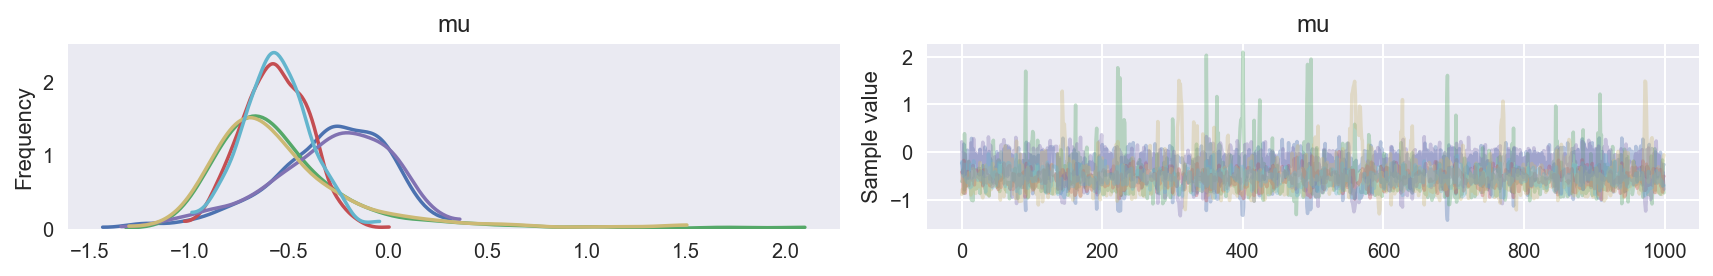

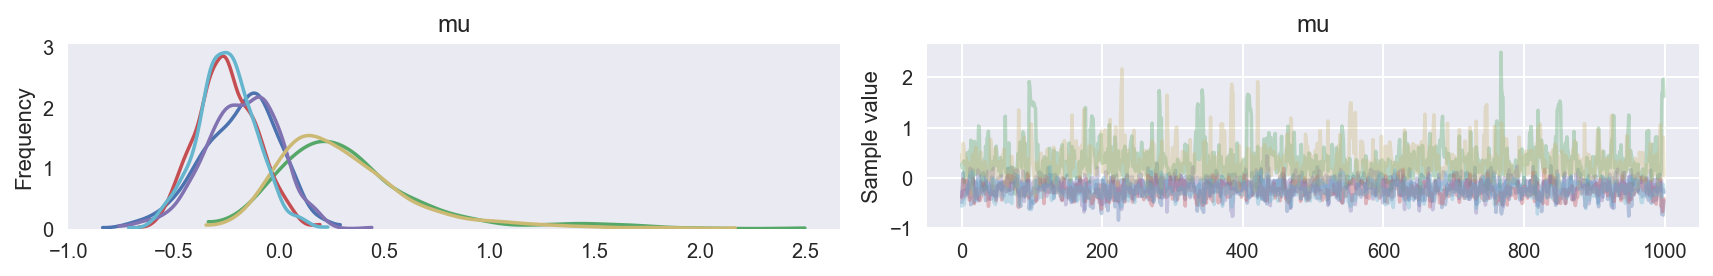

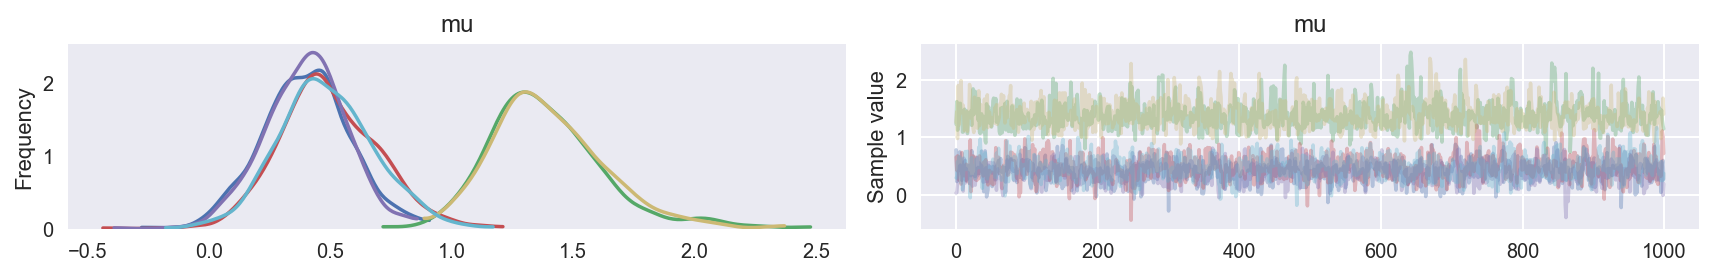

In [7]:
for trial in np.arange(Nt):
    pm.traceplot(indiv_trial2[trial], varnames=['mu']);

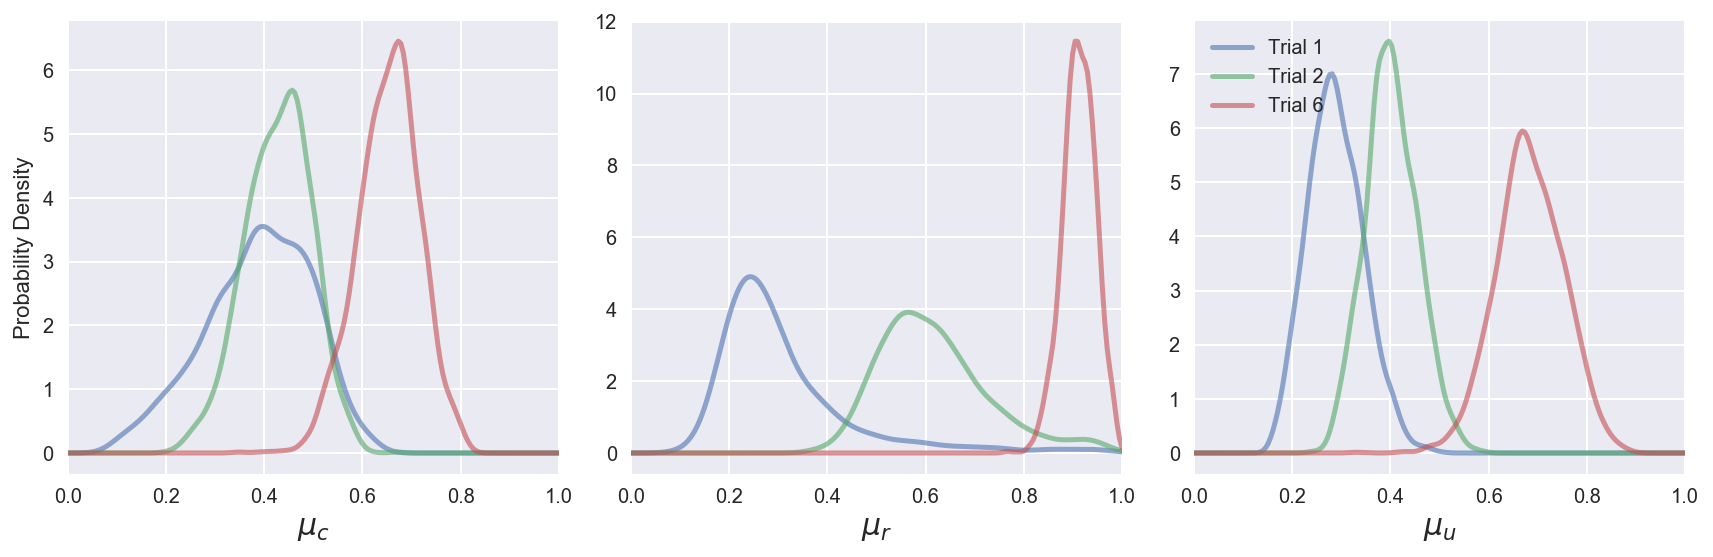

In [8]:
import scipy.special as sp

_, axes = plt.subplots(1, 3, figsize=(12, 4))
x1 = np.linspace(0, 1, 200)
plotparm = [r'$\mu_c$', r'$\mu_r$', r'$\mu_u$']
trialname = ['Trial 1', 'Trial 2', 'Trial 6']


def npPhi(x):
    # probit transform
    return (1.0 + sp.erf(x / np.sqrt(2.0))) / 2.0


for trial in np.arange(Nt):
    mupost = indiv_trial2[trial]['mu']
    for ip, ii in enumerate(plotparm):
        cpost = npPhi(mupost[:, ip])
        my_pdf = gaussian_kde(cpost)
        # distribution function
        axes[ip].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)
        axes[ip].set_xlim([0, 1])
        axes[ip].set_xlabel(ii, fontsize=15)

axes[0].set_ylabel('Probability Density')
plt.legend(trialname, loc='upper left')
plt.tight_layout()

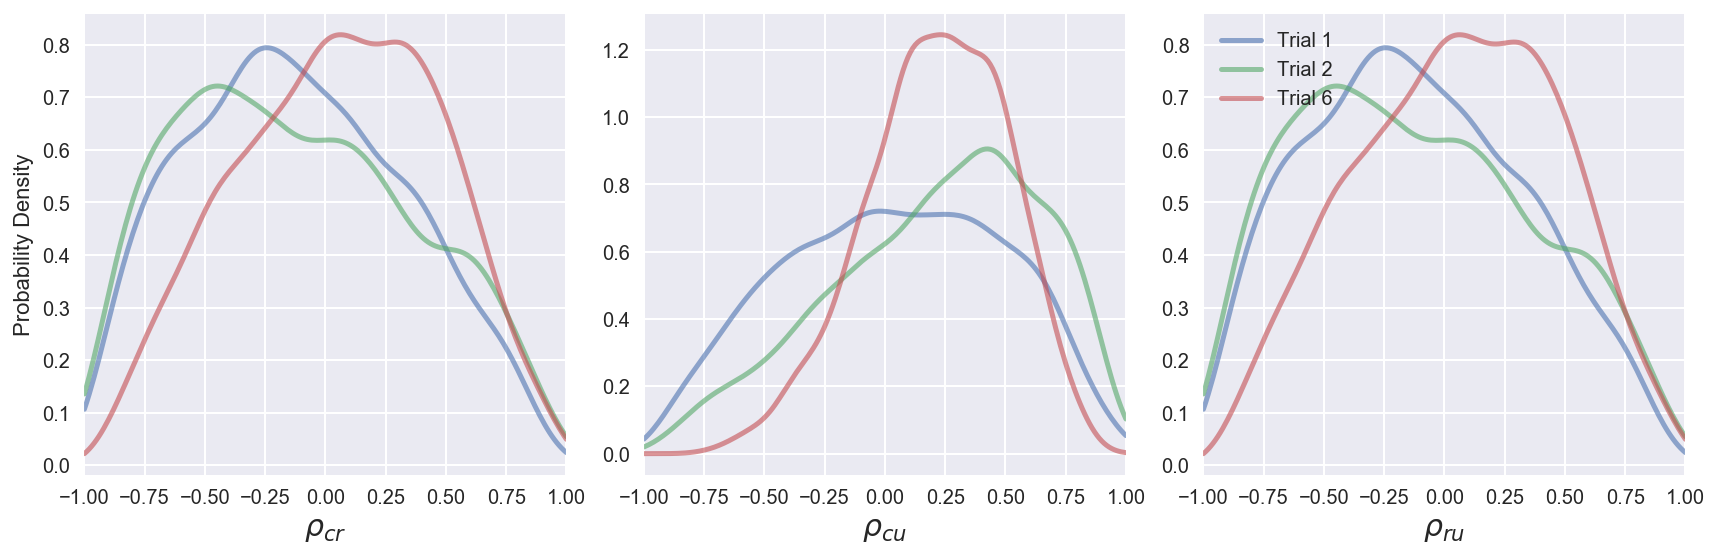

In [9]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
x1 = np.linspace(-1, 1, 200)
plotparm2=[r'$\rho_{cr}$', r'$\rho_{cu}$', r'$\rho_{ru}$']

for trial in np.arange(Nt):
    sigmainvpost=indiv_trial2[trial]['wishart']
    tmpn=sigmainvpost.shape[0]
    sigmapost=np.ndarray((tmpn, 3, 3), dtype=float)
    for i in range(tmpn):
        sigmapost[i, :, :]=np.linalg.inv(sigmainvpost[i, :, :])
        
    cpost0 = sigmapost[:, 0, 1]/np.sqrt(sigmapost[:, 0, 0]*sigmapost[:, 1, 1])
    my_pdf = gaussian_kde(cpost0)
    axes[0].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
    
    cpost1 = sigmapost[:, 0, 2]/np.sqrt(sigmapost[:, 0, 0]*sigmapost[:, 2, 2])
    my_pdf = gaussian_kde(cpost1)
    axes[1].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
    
    cpost2 = sigmapost[:, 1, 2]/np.sqrt(sigmapost[:, 1, 1]*sigmapost[:, 2, 2])
    my_pdf = gaussian_kde(cpost0)
    axes[2].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6) # distribution function
    
axes[0].set_ylabel('Probability Density')
axes[0].set_xlim([-1, 1])
axes[0].set_xlabel(plotparm2[0], fontsize=15)
axes[1].set_xlim([-1, 1])
axes[1].set_xlabel(plotparm2[1], fontsize=15)
axes[2].set_xlim([-1, 1])
axes[2].set_xlabel(plotparm2[2], fontsize=15)
plt.legend(trialname, loc='upper left')
plt.tight_layout()

The above model works fine, but using Wishart is highly discouraged, including the Wishart-Bartlett form. Below we reparameterized the model using a LKJ distribution (Cholesky decomposed version) as prior for covariance matrix.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vals_raw, chol_cov_cholesky_cov_packed__, xi_log__, mu]
100%|██████████| 2000/2000 [03:14<00:00, 10.29it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.703463896908319, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


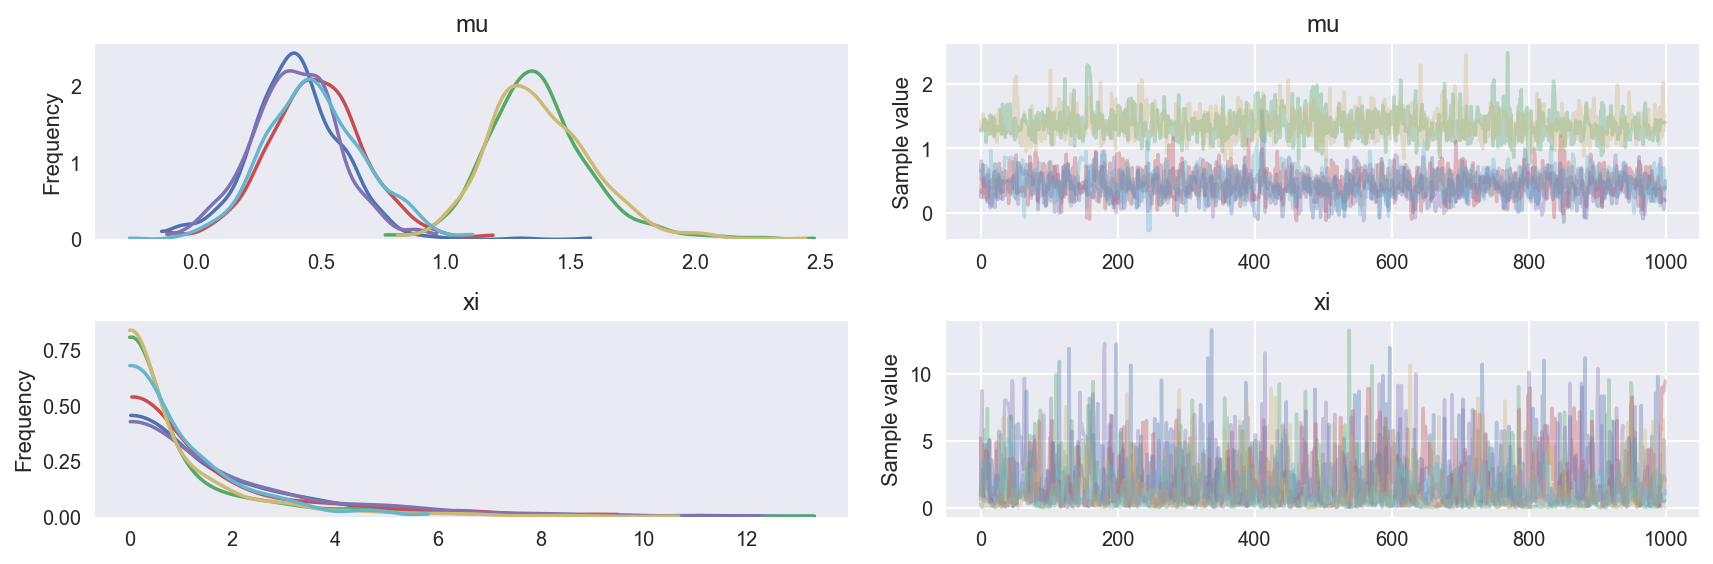

In [14]:
with pm.Model() as modelk:
    mu = pm.Normal('mu', mu=0, sd=1, shape=Nt)
    xi = pm.HalfNormal('xi', sd=5, shape=Nt)

    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nt, eta=1, sd_dist=sd_dist)
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(Nt, packed_chol, lower=True)

    vals_raw = pm.Normal('vals_raw', mu=0, sd=1, shape=(Nt, Nsubj))
    delta = tt.dot(chol, vals_raw).T
    
    c = Phi(mu[0] + xi[0] * delta[:, 0])
    r = Phi(mu[1] + xi[1] * delta[:, 1])
    u = Phi(mu[2] + xi[2] * delta[:, 2])

    t1 = c*r
    t2 = (1-c)*(u**2)
    t3 = 2*u*(1-c)*(1-u)
    t4 = c*(1-r)+(1-c)*(1-u)**2

    muc = pm.Deterministic('muc', Phi(mu[0]))
    mur = pm.Deterministic('mur', Phi(mu[1]))
    muu = pm.Deterministic('muu', Phi(mu[2]))

    p_ = tt.stack([t1, t2, t3, t4])
    kobs = pm.Multinomial('kobs', p=p_.T, n=Nitem, observed=kall[2])
    trace = pm.sample(1000, tune=1000, init='adapt_diag')
    
pm.traceplot(trace, varnames=['mu', 'xi']);

Compare with the result using wishart prior

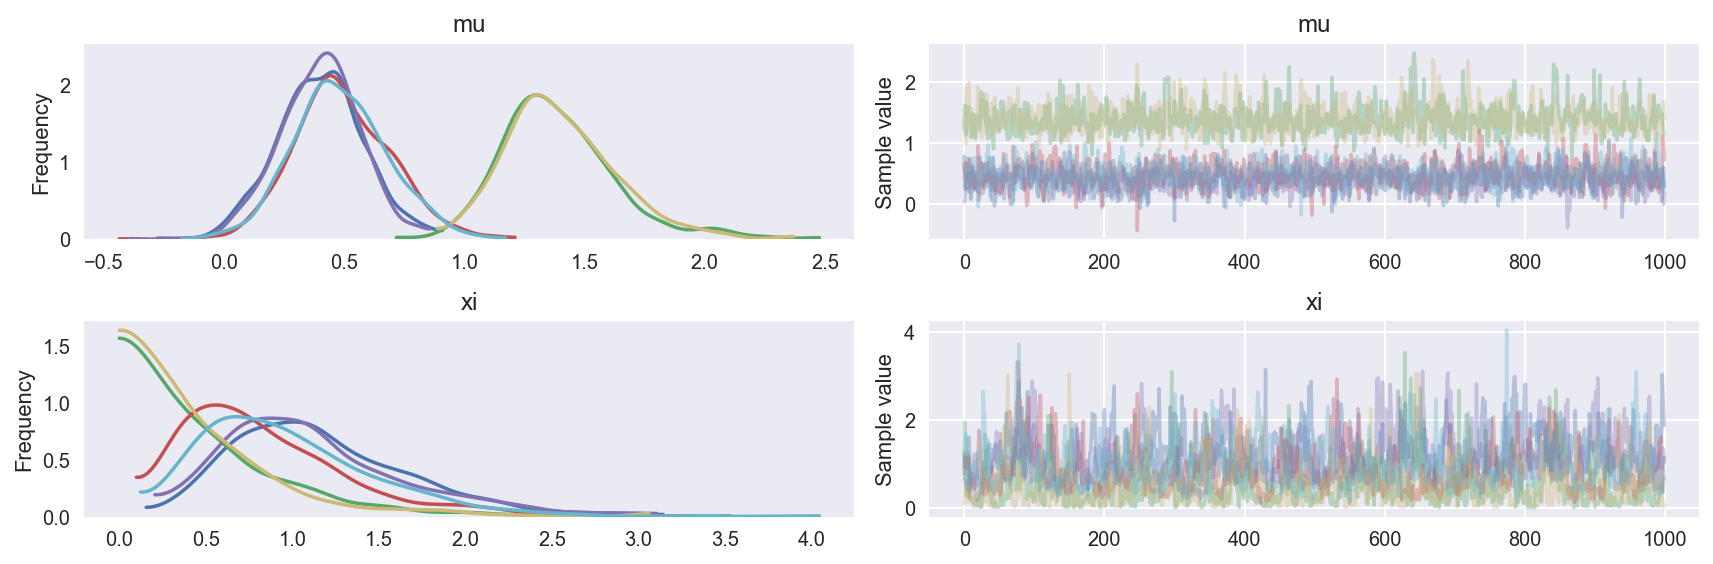

In [11]:
pm.traceplot(indiv_trial2[2], varnames=['mu', 'xi']);